In [1]:
! pip install spacy diffusers transformers accelerate torch torchvision pillow langchain openai langchain_groq

INFO: pip is looking at multiple versions of langchain-groq to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 5.3 MB/s eta 0:00:00


In [2]:
import spacy

nlp = spacy.load("en_core_web_sm")

def segment_narrative(text):
    doc = nlp(text)
    segments = [sent.text.strip() for sent in doc.sents]
    segments = [s for s in segments if len(s.split()) > 3]
    return segments

In [40]:
pitch = """
VeloCity is reimagining how people move through their cities.
Our AI-powered e-bikes automatically adjust speed, route, and energy based on traffic and weather.
Riders glide effortlessly through smart lanes lit by dynamic LED paths that respond to motion.
At every turn, VeloCity makes urban commuting faster, greener, and more connected — turning every ride into an experience, not a chore.
"""

scenes = segment_narrative(pitch)
scenes

['VeloCity is reimagining how people move through their cities.',
 'Our AI-powered e-bikes automatically adjust speed, route, and energy based on traffic and weather.',
 'Riders glide effortlessly through smart lanes lit by dynamic LED paths that respond to motion.',
 'At every turn, VeloCity makes urban commuting faster, greener, and more connected — turning every ride into an experience, not a chore.']

In [4]:
from google.colab import userdata
import os

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [12]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

# Initialize Groq model
llm = ChatGroq(
    model="llama-3.3-70b-versatile",  # you can also use "mixtral-8x7b" or "gemma-7b-it"
    temperature=0.7
)

prompt_template = ChatPromptTemplate.from_messages([
    ("system",
     """You are an expert visual storyteller and AI prompt engineer.
     Your task is to transform a simple sales or marketing sentence into a
     cinematic, detailed, and visually striking prompt ready for image generation models
     like Stable Diffusion, SDXL, or Midjourney.

     Objective:
     - Capture the *essence* of the sales message or product vision.
     - Describe a single compelling scene that visually represents that message.
     - The prompt must be directly usable by an image generation model.

     Style & Structure Guidelines:
     - Start directly with the visual scene (no introductions, no quotes, no meta text).
     - Be concrete and sensory-rich — describe the setting, lighting, colors, mood, and atmosphere.
     - Include visual composition cues (e.g., “wide-angle shot”, “soft lighting”, “inspired by concept art”).
     - Optionally, include cinematic or artistic style hints (e.g., “studio photography”, “digital painting”, “isometric view”).
     - Keep the emotional tone consistent with the sales or marketing message — professional, visionary, and inspiring.
     - Avoid repetition, irrelevant fantasy elements, or abstract metaphors.
     - Write in one cohesive paragraph (2–4 sentences max).
     - The final output must be **concise and within 77 tokens** total to ensure compatibility with image generation models.

     Maintain a {style} tone throughout.
     """),
    ("user", "Sentence: {segment}")
])


def enhance_prompt_with_llm(text: str, style: str = "professional") -> list:
    """
    Splits the given text into sentences, enhances each one with LLM,
    and returns a list of enhanced sentences.
    """

    segments = segment_narrative(text)

    enhanced_segments = []

    for segment in segments:
        formatted_prompt = prompt_template.format_messages(style=style, segment=segment)
        response = llm.invoke(formatted_prompt)
        enhanced_text = response.content.strip()
        enhanced_segments.append(enhanced_text)


    return enhanced_segments

In [41]:
scenes = enhance_prompt_with_llm(pitch)
scenes

['Aerial view of a bustling city, soft lighting, with sleek transportation systems, vibrant green spaces, and modern architecture, inspired by futuristic concept art, conveying a sense of innovation and harmony.',
 "A sleek, silver e-bike glides through a bustling city street at dawn, soft lighting reflecting off wet pavement, as morning fog lifts, with a wide-angle shot capturing the bike's intuitive interface and the rider's confident smile, inspired by futuristic concept art.",
 'Riders glide through smart lanes on a curved, futuristic road, lit by dynamic LED paths responding to motion, under a soft, blue-purple dusk sky.',
 'A wide-angle shot of a bustling city street, with a sleek VeloCity bike lane weaving through, lined with greenery and vibrant street art, under soft, warm lighting, capturing the essence of efficient and sustainable urban mobility.']

In [17]:
from diffusers import StableDiffusionXLPipeline

model_id = "stabilityai/sdxl-turbo"
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe_new = StableDiffusionXLPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
).to(device)

model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [44]:
def generate_images_from_text(prompts, pipe, output_dir="generated_images"):
    os.makedirs(output_dir, exist_ok=True)

    for i, prompt in enumerate(prompts, 1):
        print(f"Generating image {i}/{len(prompts)} ...")
        image = pipe_new(
            prompt,
            guidance_scale=1.5,
            num_inference_steps=5
        ).images[0]

        # Save image
        path = os.path.join(output_dir, f"scene_{i}.png")
        image.save(path)
        print(f"Saved: {path}")

        # Display image inline (for notebook)
        display(image)

Generating image 1/4 ...


  0%|          | 0/5 [00:00<?, ?it/s]

Saved: generated_images/scene_1.png


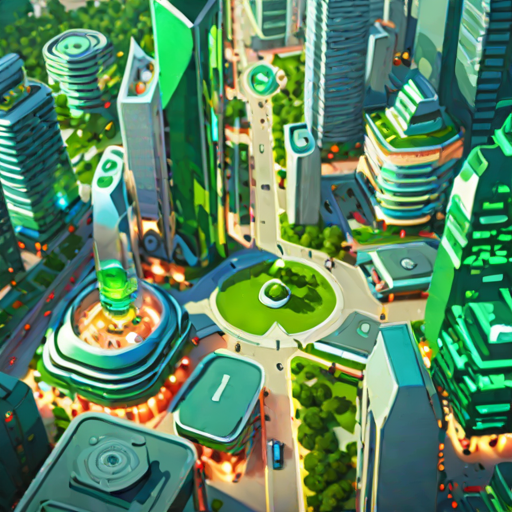

Generating image 2/4 ...


  0%|          | 0/5 [00:00<?, ?it/s]

Saved: generated_images/scene_2.png


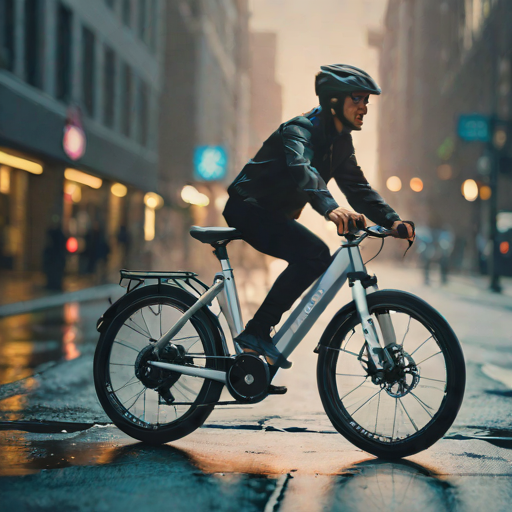

Generating image 3/4 ...


  0%|          | 0/5 [00:00<?, ?it/s]

Saved: generated_images/scene_3.png


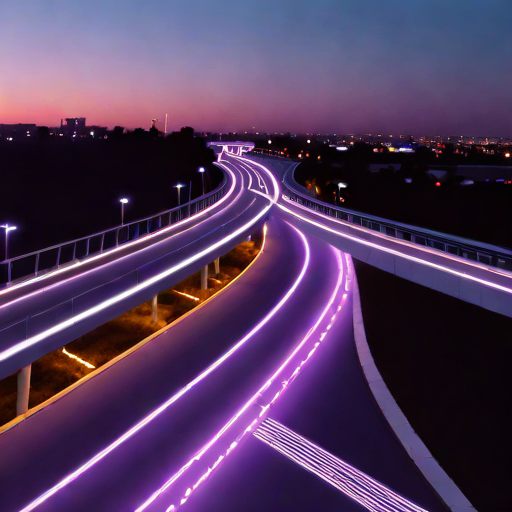

Generating image 4/4 ...


  0%|          | 0/5 [00:00<?, ?it/s]

Saved: generated_images/scene_4.png


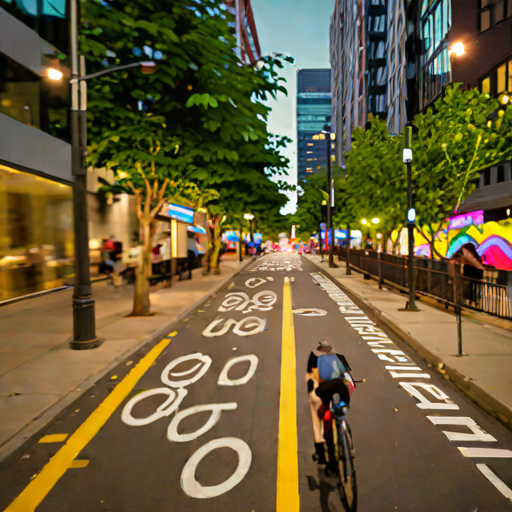

In [45]:
generate_images_from_text(scenes, pipe)